# Preprocessing

In [100]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# minute data
df = pd.read_csv("data.csv")
df["Date"] = pd.to_datetime(df.Date)
df.index = df.Date
df.drop(["Timestamp", "Date", "Symbol", "Volume USD"], axis=1, inplace=True)
df.columns = ['open', 'high', 'low', 'close', 'Volume_BTC']
df = df.iloc[::-1]

In [206]:
import yfinance as yf
start_date = datetime.datetime(2018, 1, 1)
end_date = datetime.datetime(2024, 1, 1)
btc_info = yf.Ticker("BTC-USD")

# pass the parameters as the taken dates for start and end
df = btc_info.history(start = start_date, end = end_date)

In [208]:
df.corr()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Open,1.000000,0.999236,0.998658,0.998200,0.488384,NaN,NaN
High,0.999236,1.000000,0.998438,0.999185,0.497442,NaN,NaN
Low,0.998658,0.998438,1.000000,0.999046,0.472247,NaN,NaN
Close,0.998200,0.999185,0.999046,1.000000,0.486413,NaN,NaN
Volume,0.488384,0.497442,0.472247,0.486413,1.000000,NaN,NaN
Dividends,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Stock Splits,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [197]:
fng_index = pd.read_csv("fng_index.csv")

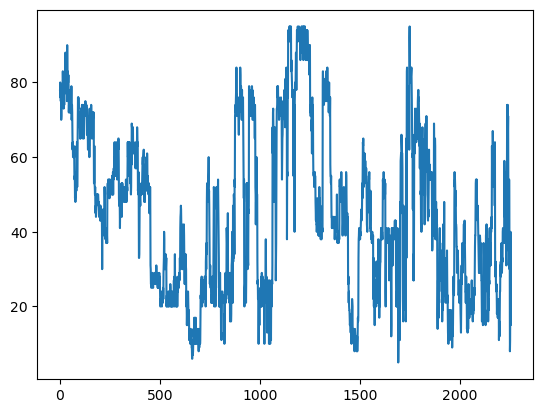

In [199]:
plt.plot(fng_index.fng_value)

In [22]:
#df.drop(columns = ["open", "high", "low"], inplace = True)

In [93]:
#df["rsi"] = ta.rsi(df.close)

In [101]:
df_price = df.copy()
df_price["Volume_BTC"] = np.log(1+df_price["Volume_BTC"])

In [122]:
df_diff = df_price.diff()
df_diff["rsi"] = ta.rsi(df_price.close)

In [139]:
df_diff.corr()

,open,high,low,close,Volume_BTC,rsi
open,1.000000,0.499289,0.510493,-0.003562,-0.002340,0.103573
high,0.499289,1.000000,0.480221,0.586852,0.105604,0.123202
low,0.510493,0.480221,1.000000,0.563754,-0.132032,0.116860
close,-0.003562,0.586852,0.563754,1.000000,-0.014290,0.114554
Volume_BTC,-0.002340,0.105604,-0.132032,-0.014290,1.000000,-0.002254
rsi,0.103573,0.123202,0.116860,0.114554,-0.002254,1.000000


In [24]:
df_return = df.copy()
df_return["Volume_BTC"] += 1
df_return = np.log(df_return/df_return.shift())
df_return.rename(columns = {"close": "return"}, inplace = True)

In [146]:
class preprocessing():
    def __init__(self, df):
        self.df = df
    
    def split(self, df, start, test_start, end):
        # Select the last quarter as the training dataset
        date_index = pd.to_datetime(df.index)
        mask_train = pd.Series(date_index).between(start, test_start, inclusive="left")
        df_train = df.loc[mask_train.values].copy(deep=True)

        mask_test = pd.Series(date_index).between(test_start, end, inclusive="left")
        df_test = df.loc[mask_test.values].copy(deep=True)

        return df_train, df_test
    
    def m_dist(self, df_train):
        X = df_train.values
        m = X.mean(axis = 0)
        X_minus_m = X - m
        S = np.cov(X.T)
        S_inv = np.linalg.inv(S)
        maha_dist = np.array([X_minus_m[i]@S_inv@X_minus_m[i] for i in range(X.shape[0])])
        return maha_dist
    
    def outliers_indexing(self, df_train, quantile = 0.999):
        maha_dist = self.m_dist(df_train)
        is_outlier =  (maha_dist > np.quantile(maha_dist, quantile))
        return is_outlier

    def transform(self, df_train, df_test, method = "minmax", y_name = "close"):
        df_train = df_train.copy(deep=True)
        df_test = df_test.copy(deep=True)
        X_names = list(df_train.columns[df_train.columns != y_name])

        if method == "std":
            self.scaler_y = StandardScaler()
            self.scaler = StandardScaler()
        elif method == "minmax":
            self.scaler_y = MinMaxScaler()
            self.scaler = MinMaxScaler()
        
        self.scaler_y.fit(df_train[[y_name]])
        self.scaler.fit(df_train[X_names])
        df_train.loc[:, [y_name]] = self.scaler_y.transform(df_train[[y_name]])
        df_train.loc[:, X_names] = self.scaler.transform(df_train[X_names])
        df_test.loc[:, [y_name]] = self.scaler_y.transform(df_test[[y_name]])
        df_test.loc[:, X_names] = self.scaler.transform(df_test[X_names])

        return df_train, df_test
    
    def generate_dataset(self, df_train, seq_len, y_name = "close"):
        X_list, y_list = [], []
        for i in range(len(df_train.index) - seq_len):
            if df_train.iloc[i:i + 1 + seq_len,:].isna().any(axis = None):
                continue
            X_list.append(np.array(df_train.iloc[i:i+seq_len,:]))
            y_list.append(df_train[y_name].values[i+seq_len])
        return np.array(X_list), np.array(y_list)
    
    def pipeline(self, 
                 split_args = {"start": "2021-10-01", 
                               "test_start": "2021-12-31", 
                               "end" :"2022-01-01"}, 
                 outliers_indexing_args = {"quantile": 0.99}, 
                 transform_args = {"method": "minmax", 
                                   "y_name": "close"}, 
                 generate_dataset_args = {"seq_len": 5}, LAG = 5):
        self.df_train, self.df_test = self.split(self.df, **split_args)
        self.is_outlier = self.outliers_indexing(self.df_train, **outliers_indexing_args)
        self.df_train.iloc[self.is_outlier, :] = np.nan
        self.df_train_transformed, self.df_test_transformed = self.transform(self.df_train, self.df_test, **transform_args)
        
        # Add LAG number of observations in training dataset to test dataset
        df_test_LAG = pd.concat((self.df_train_transformed.iloc[-LAG:,:], self.df_test_transformed), axis=0)

        self.X_train, self.y_train = self.generate_dataset(self.df_train_transformed, seq_len=LAG)
        self.X_test, self.y_test = self.generate_dataset(df_test_LAG, seq_len=LAG)

In [148]:
pp = preprocessing(df_diff)
pp.pipeline(LAG = 30, split_args = {"start": "2021-12-01", 
                               "test_start": "2021-12-31", 
                               "end" :"2022-01-01"})

In [149]:
X_train = pp.X_train
X_test = pp.X_test
y_train = pp.y_train
y_test = pp.y_test

In [150]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((38202, 30, 6), (38202,), (1440, 30, 6), (1440,))

# Model

In [151]:
print(np.mean(y_train))
print(np.mean((y_train - np.mean(y_train))**2))
print(np.mean((y_test - np.mean(y_train))**2)**0.5)
print(np.mean((y_test - np.mean(y_test))**2))

0.5526148923780411
0.004895180818862772
0.07023516528362135
0.004932688203077308


In [200]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam
tf.keras.utils.set_random_seed(4002)
callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor='val_rmse', min_delta=0, patience=5, verbose=1,
    mode='min', baseline=None, restore_best_weights=True)]
metrics = [
    tf.keras.metrics.MeanAbsoluteError(name='mae'),
    tf.keras.metrics.RootMeanSquaredError(name='rmse')
]

model = Sequential()
model.add(LSTM(64, return_sequences=True, dropout = 0.5))
model.add(LSTM(64, dropout = 0.2))
model.add(Dense(32, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(32, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(32, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(1))

model.compile(optimizer = Adam(learning_rate = 0.001), loss='msle', metrics = metrics)
model.fit(X_train, y_train, batch_size=64, epochs=20, shuffle=True, callbacks=callbacks, validation_data = (X_test, y_test))

LSTM_pred = np.squeeze(model.predict(X_test))
print(np.mean((LSTM_pred - y_test)**2))

Epoch 1/20
597/597 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0207 - mae: 0.1560 - rmse: 0.2077 - val_loss: 0.0021 - val_mae: 0.0497 - val_rmse: 0.0714
Epoch 2/20
597/597 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0040 - mae: 0.0752 - rmse: 0.0969 - val_loss: 0.0021 - val_mae: 0.0489 - val_rmse: 0.0707
Epoch 3/20
597/597 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0026 - mae: 0.0595 - rmse: 0.0792 - val_loss: 0.0021 - val_mae: 0.0484 - val_rmse: 0.0703
Epoch 4/20
597/597 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0022 - mae: 0.0521 - rmse: 0.0717 - val_loss: 0.0021 - val_mae: 0.0483 - val_rmse: 0.0702
Epoch 5/20
597/597 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0021 - mae: 0.0503 - rmse: 0.0702 - val_loss: 0.0021 - val_mae: 0.0483 - val_rmse: 0.0702
Epoch 6/20
597/597 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0020 - mae: 0.0498 - rmse: 0.0698 - val_loss: 0.0021 - val_mae: 0.0483 - val_rmse: 0.0702
Epoch 7/20
597/597 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0020 - mae: 0.0497

In [68]:
model = Sequential()
model.add(Conv1D(filters=80, kernel_size=5,padding='same',activation='relu',kernel_initializer="glorot_uniform"))
model.add(MaxPooling1D(pool_size=2, padding='valid'))
model.add(LSTM(8, return_sequences=False, dropout = 0.5))
model.add(Dense(1))

model.compile(optimizer = Adam(learning_rate = 0.001), loss='mse', metrics = metrics)
model.fit(X_train, y_train, batch_size=64, epochs=20, shuffle=True, callbacks=callbacks, validation_data = (X_test, y_test))

LSTM_pred = np.squeeze(model.predict(X_test))
print(np.mean((LSTM_pred - y_test)**2))

Epoch 1/20
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0175 - mae: 0.0800 - rmse: 0.1171 - val_loss: 0.0101 - val_mae: 0.0696 - val_rmse: 0.1009
Epoch 2/20
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0078 - mae: 0.0641 - rmse: 0.0884 - val_loss: 0.0101 - val_mae: 0.0692 - val_rmse: 0.1007
Epoch 3/20
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0078 - mae: 0.0638 - rmse: 0.0882 - val_loss: 0.0101 - val_mae: 0.0691 - val_rmse: 0.1006
Epoch 4/20
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0078 - mae: 0.0638 - rmse: 0.0881 - val_loss: 0.0101 - val_mae: 0.0691 - val_rmse: 0.1006
Epoch 5/20
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0078 - mae: 0.0637 - rmse: 0.0881 - val_loss: 0.0100 - val_mae: 0.0691 - val_rmse: 0.1006
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step   
0.01017884368431865


In [72]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 30, 32)         │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 30, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,813 (257.09 KB)

 Trainable params: 21,937 (85.69 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 43,876 (171.39 KB)

In [144]:
test_close = df[(df.index >= "2021-12-31")*(df.index < "2022-01-01")].close.copy()
pred_log_return = pp.scaler_y.inverse_transform(LSTM_pred.reshape((-1,1))).squeeze()
naive_pred = df[(df.index >= "2021-12-30 23:59:00")*(df.index < "2021-12-31 23:59:00")].close.values
pred_close = np.exp(pred_log_return)*naive_pred
print(f"naive: {np.mean((test_close - naive_pred)**2)}")
print(f"model: {np.mean((test_close - pred_close)**2)}")

naive: 1442.4443819444505
model: 152418178.09695938


In [201]:
test_close = df[(df.index >= "2021-12-31")*(df.index < "2022-01-01")].close.copy()
pred_diff = pp.scaler_y.inverse_transform(LSTM_pred.reshape((-1,1))).squeeze()
naive_pred = df[(df.index >= "2021-12-30 23:59:00")*(df.index < "2021-12-31 23:59:00")].close.values
pred_close = naive_pred + pred_diff
print(f"naive: {np.mean((test_close - naive_pred)**2)}")
print(f"model: {np.mean((test_close - pred_close)**2)}")

naive: 1442.4443819444505
model: 1442.277133317844


In [367]:
np.mean(pp.scaler_y.inverse_transform(y_test.reshape((-1,1)))**2)

6.493361400997116e-07

In [368]:
np.mean((pp.scaler_y.inverse_transform(y_test.reshape((-1,1))) - pred_log_return)**2)

6.491830593202938e-07

In [40]:
print(f"naive: {np.mean((test_close - naive_pred)**2)}")
print(f"model: {np.mean((test_close - pred_close)**2)}")

naive: 1442.4443819444505
model: 1441.9376899240583


In [373]:
np.mean((test_close - pred_close)**2)

1442.0468943427986

In [374]:
1 - np.mean((test_close - pred_close)**2)/np.mean((test_close - test_close.mean())**2)

0.9972264389756041

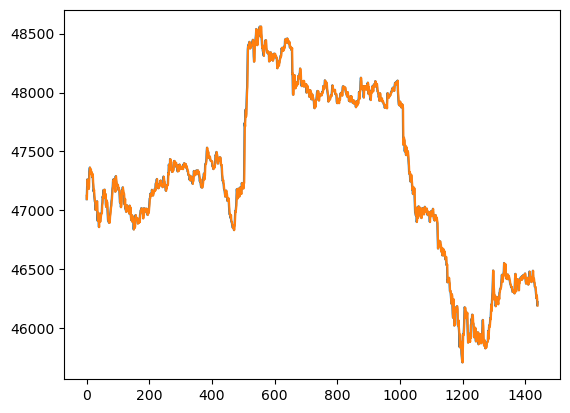

In [118]:
plt.plot(test_close.values)
plt.plot(pred_close)

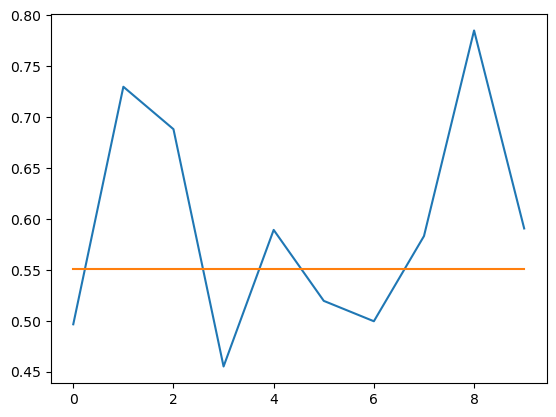

In [202]:
from matplotlib import pyplot as plt
plt.plot(y_test[:10])
plt.plot(LSTM_pred[:10])

In [120]:
y_test

array([0.47907782, 0.70409165, 0.66390678, ..., 0.48045181, 0.43266537,
       0.58660623])

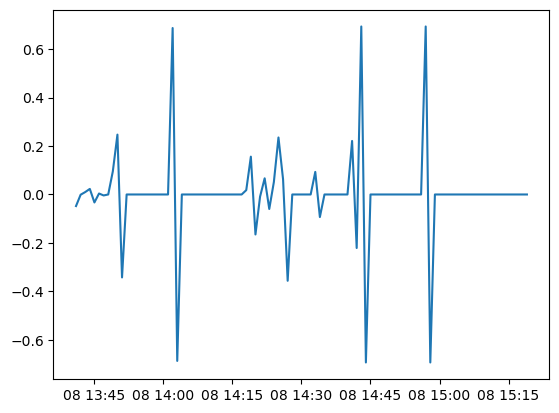

In [412]:
plt.plot(df_diff.Volume_BTC[:100])

In [413]:
df_diff.corr()

,return,Volume_BTC
return,1.000000,-0.014384
Volume_BTC,-0.014384,1.000000


In [402]:
LSTM_pred[:10] - LSTM_pred.mean()

array([-3.5762787e-07, -1.1920929e-07, -1.7881393e-07, -1.1920929e-07,
        0.0000000e+00, -5.3644180e-07, -8.9406967e-07, -8.9406967e-07,
       -8.9406967e-07, -7.7486038e-07], dtype=float32)

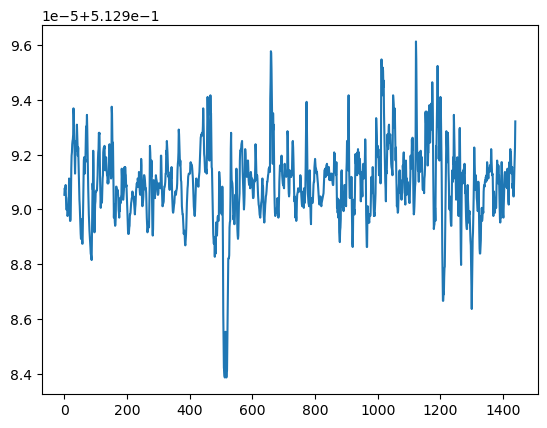

In [394]:
plt.plot(LSTM_pred)